# Time Series Forecasting with sktime

- https://github.com/sktime/sktime
- https://www.sktime.net/en/stable/examples/00_sktime_intro.html
- https://www.sktime.net/en/stable/examples/01_forecasting.html
- https://www.sktime.net/en/stable/examples/01a_forecasting_sklearn.html

## Background

- Forecasting is not the same as supervised prediction;

- Even though forecasting can be "solved" by algorithms for supervised prediction, this is indirect and requires careful composition;

- From an interface perspective, this is correctly formulated as "reduction", i.e., use of a supervised predictor as a component within a forecaster;

- There are a number of pitfalls if this is manually done - such as, over-optimistic performance evaluation, information leakage, or "predicting the past" type errors.

A common mistake is to misidentify a forecasting problem as supervised regression - after all, in both we predict numbers, so surely this must be the same thing?

Indeed we predict numbers in both, but the set-up is different:

- In supervised regression, we predict label/target variables from feature variables, in a cross-sectional set-up. This is after training on label/feature examples.

- In forecasting, we predict future values from past values, of the same variable, in a temporal/sequential set-up. This is after training on the past.

In the common data frame representation:

- In supervised regression, we predict entries in a column from other columns. For this, we mainly make use of the statistical relation between those columns, learnt from examples of complete rows. The rows are all assumed exchangeable.

- In forecasting, we predict new rows, assuming temporal ordering in the rows. For this, we mainly make use of the statistical relation between previous and subsequent rows, learnt from the example of the observed sequence of rows. The rows are not exchangeable, but in temporal sequence.

For example, consider a 10-point time series(time index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]). We aim to create a forecaster with a 5-point input window and a 1-point forecast horizon (using the past 5 data points to predict the next single future data point).

| Time Index | Data Point | Input Window (5 points) | Target (1 point) |
|------------|------------|--------------------------|-------------------|
| 0          | X0         | -                        | -                 |
| 1          | X1         | -                        | -                 |
| 2          | X2         | -                        | -                 |
| 3          | X3         | -                        | -                 |
| 4          | X4         | -                        | -                 |
| 5          | X5         | X0, X1, X2, X3, X4      | X5                |
| 6          | X6         | X1, X2, X3, X4, X5      | X6                |
| 7          | X7         | X2, X3, X4, X5, X6      | X7                |
| 8          | X8         | X3, X4, X5, X6, X7      | X8                |
| 9          | X9         | X4, X5, X6, X7, X8      | X9                |

Thus, we have a total of 5 input-target pairs. We split these into training and test sets. However, a potential pitfall arises here: if we split the data as we would with regular tabular data, leakage occurs. The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

We split the data by considering the temporal order:

Training set
| Input Window (5 points) | Target (1 point)  |
|-------------------------|-------------------|
| X0, X1, X2, X3, X4      | X5                |
| X1, X2, X3, X4, X5      | X6                |
| X2, X3, X4, X5, X6      | X7                |

Test set
| Input Window (5 points) | Target (1 point)  |
|-------------------------|-------------------|
| X3, X4, X5, X6, X7      | X8                |
| X4, X5, X6, X7, X8      | X9                |

Let's say we have a trained regression model with 5 inputs and 1 output using the training set. If we naively apply this regression model to the test set, we get incorrect results.

We actually don’t make a multi-step-ahead forecast up to the 2nd step ahead. Instead, we make 2 single-step-ahead forecasts always using the most recent data. But that’s a solution to a different learning task!

To predict X9, we **must** use [X4, X5, X6, X7, X8*] instead of [X4, X5, X6, X7, X8]. Here, X8* represents the predicted value generated by the regression model using [X3, X4, X5, X6, X7].

In [ ]:
import warnings; warnings.simplefilter('ignore')

## The basic batch forecast evaluation workflow

As the running example in this tutorial, we use a textbook data set, the Box-Jenkins airline data set, which consists of the number of monthly totals of international airline passengers, from 1949 - 1960. Values are in thousands. See "Makridakis, Wheelwright and Hyndman (1998) Forecasting: methods and applications", exercises sections 2 and 3.

In [ ]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

In [ ]:
y = load_airline()
print(y.shape)
y.head()

(144,)


Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

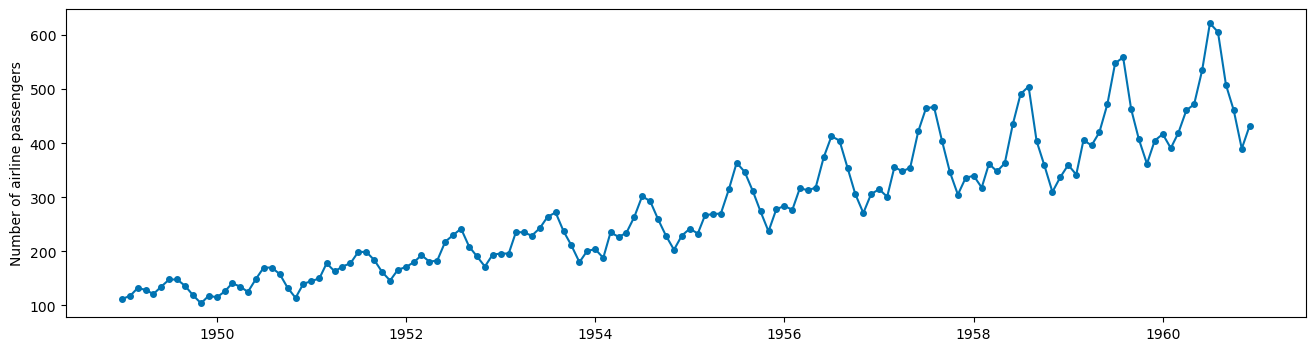

In [ ]:
plot_series(y);

In [ ]:
from sktime.split import temporal_train_test_split

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
y_train.shape, y_test.shape

((108,), (36,))

In [ ]:
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster

NaiveForecaster(sp=12)

In [ ]:
forecaster.fit(y_train)

NaiveForecaster(sp=12)

In [ ]:
y_pred = forecaster.predict(fh)
print(y_pred.shape)
y_pred.head()

(36,)


1958-01    315.0
1958-02    301.0
1958-03    356.0
1958-04    348.0
1958-05    355.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.13189432350948402

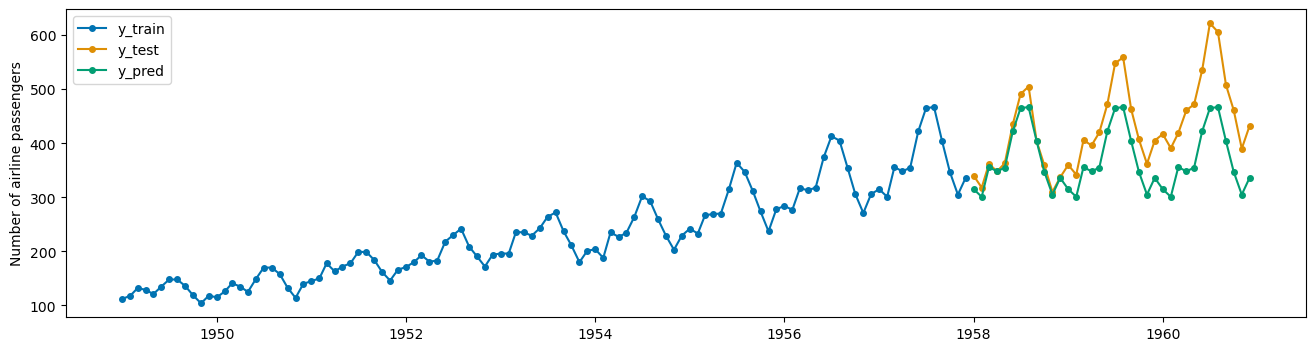

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## The basic batch forecast evaluation workflow in a nutshell

### Step 1

- Dataset
- Split
- Forcasting Horizon

In [ ]:
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [ ]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

### Step 2

- Select forecaster
- Fit
- Predict
- Plot
- Evaluation

0.13189432350948402

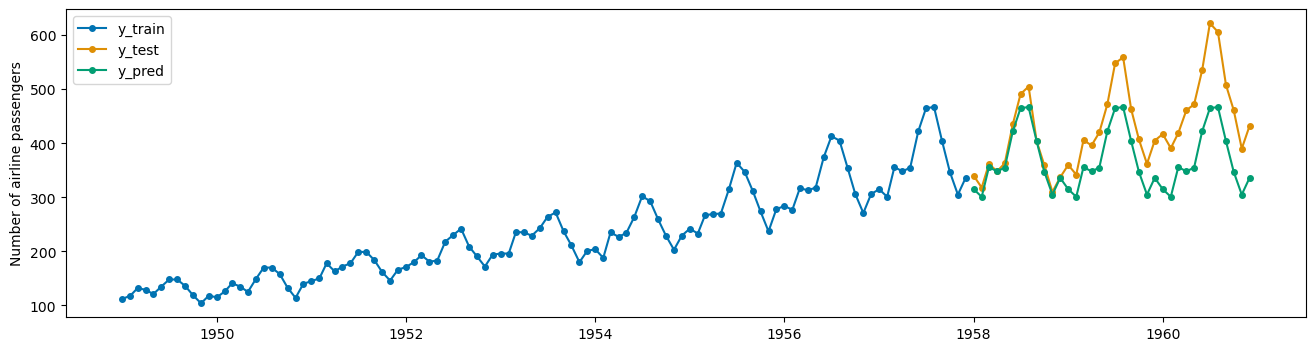

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.08174636557689717

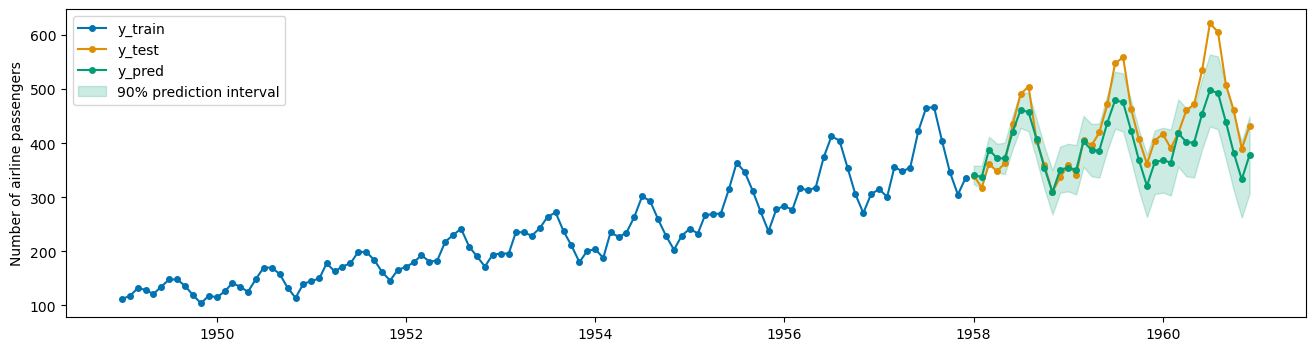

In [ ]:
from sktime.forecasting.theta import ThetaForecaster

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
converage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=converage)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], pred_interval=y_pred_ints)
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.05114163237371178

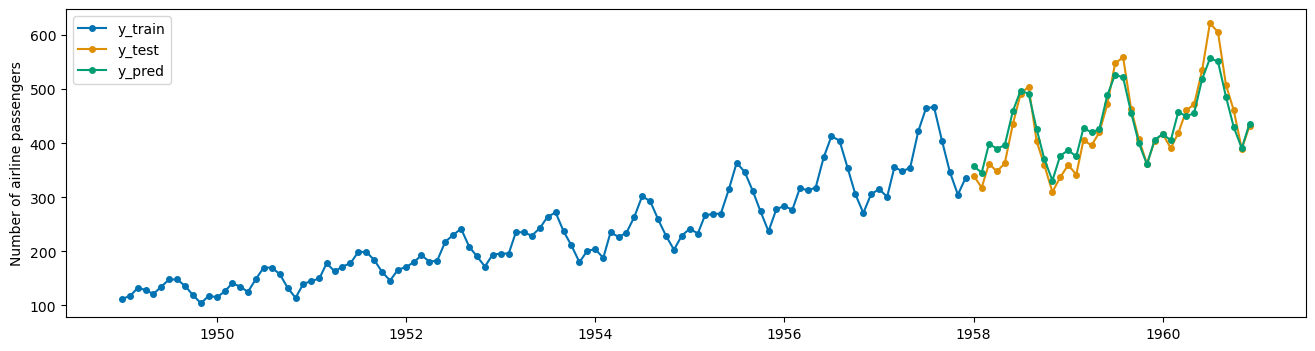

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.04356744885278522

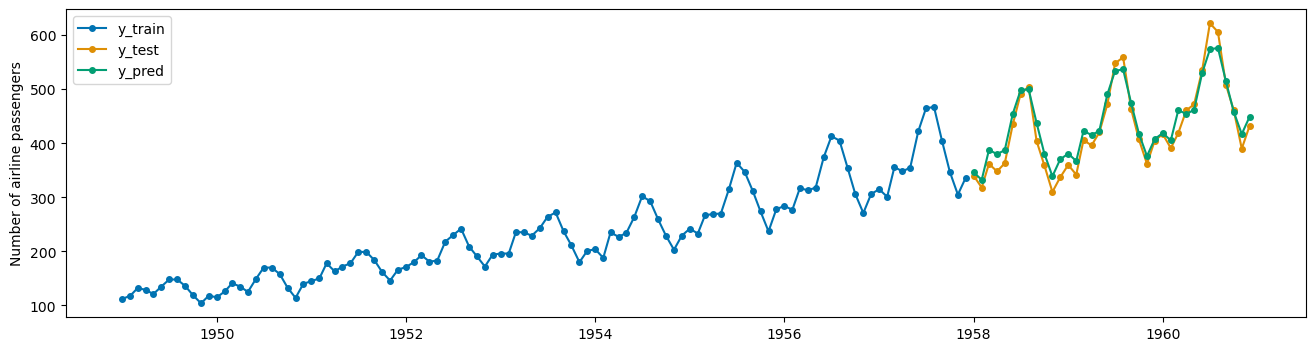

In [ ]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(
    order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.041489714388809135

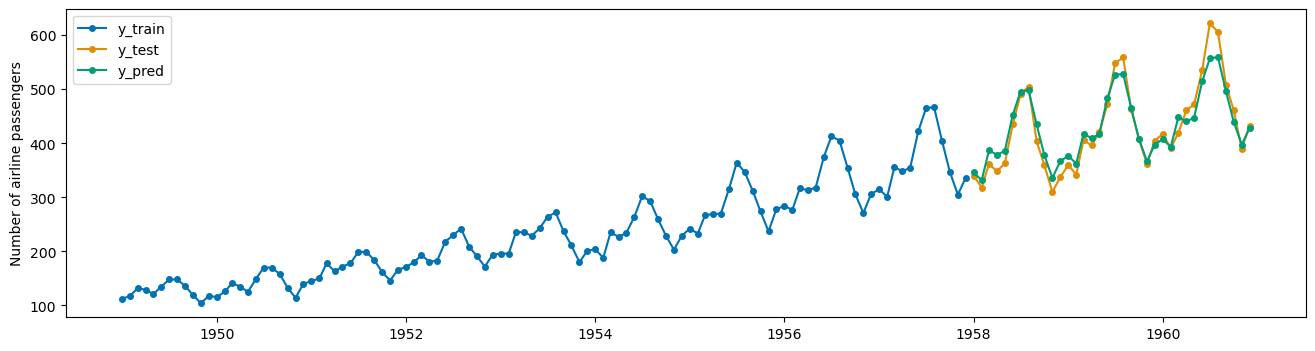

In [ ]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.08185559671753806

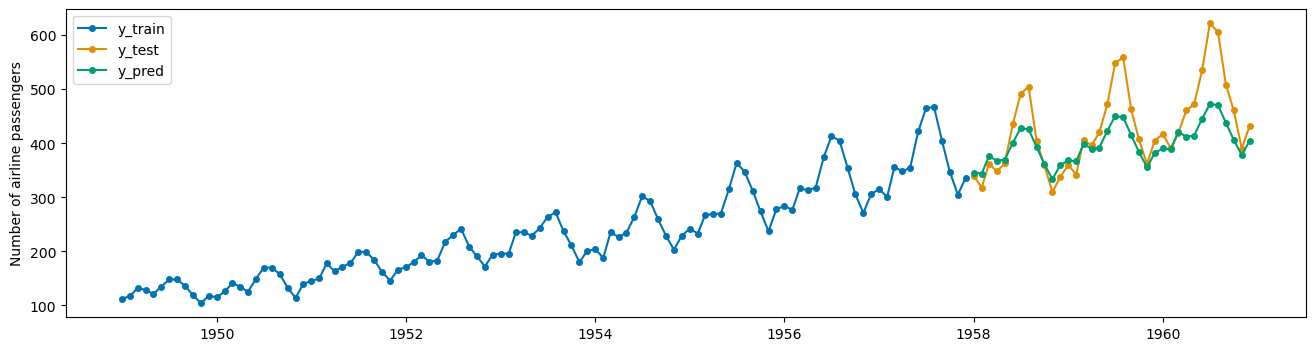

In [ ]:
from sktime.forecasting.bats import BATS

forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.08024090844021749

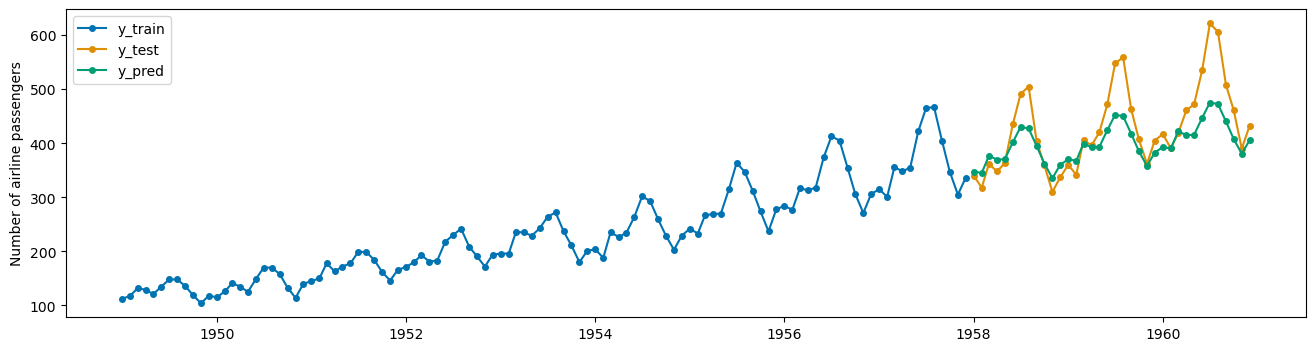

In [ ]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.049737120131209435

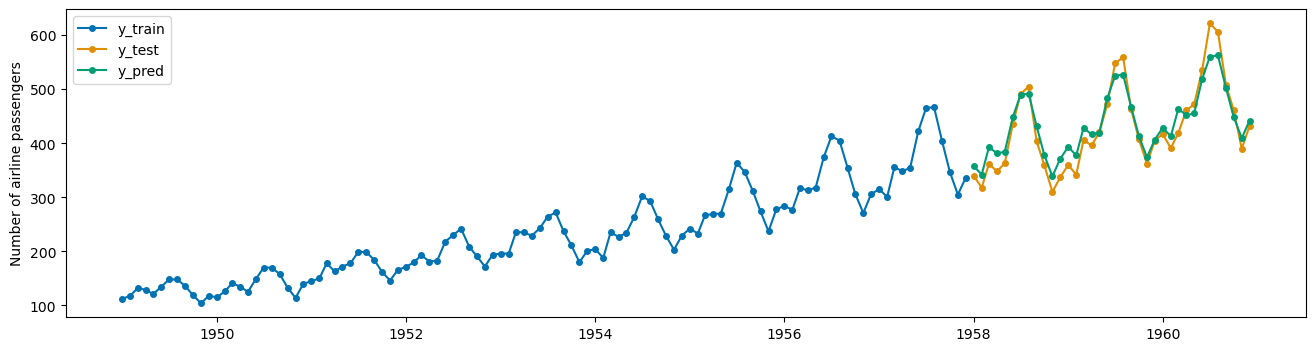

In [ ]:
from sktime.forecasting.structural import UnobservedComponents

# We can model seasonality using Fourier modes as in the Prophet model.
forecaster = UnobservedComponents(
    level="local linear trend", freq_seasonal=[{"period": 12, "harmonics": 10}]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.04149244619305738

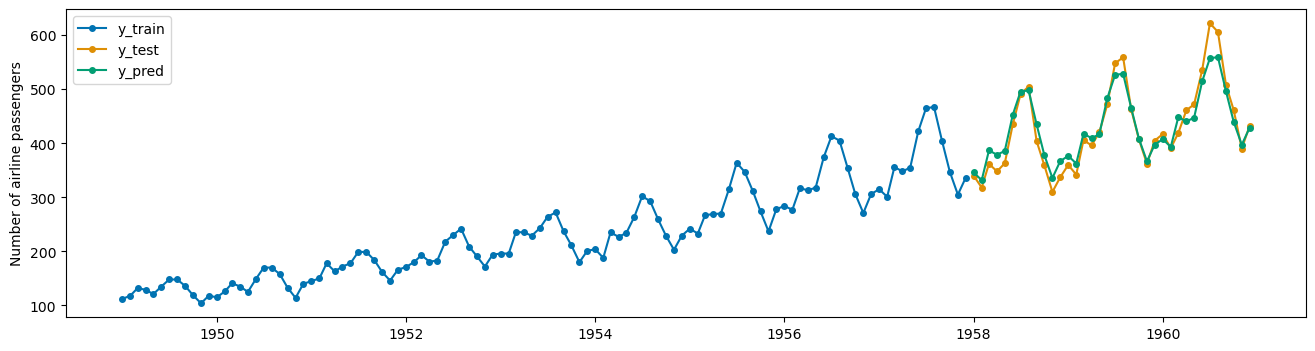

In [ ]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

forecaster = StatsForecastAutoARIMA(sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.12887507224382988

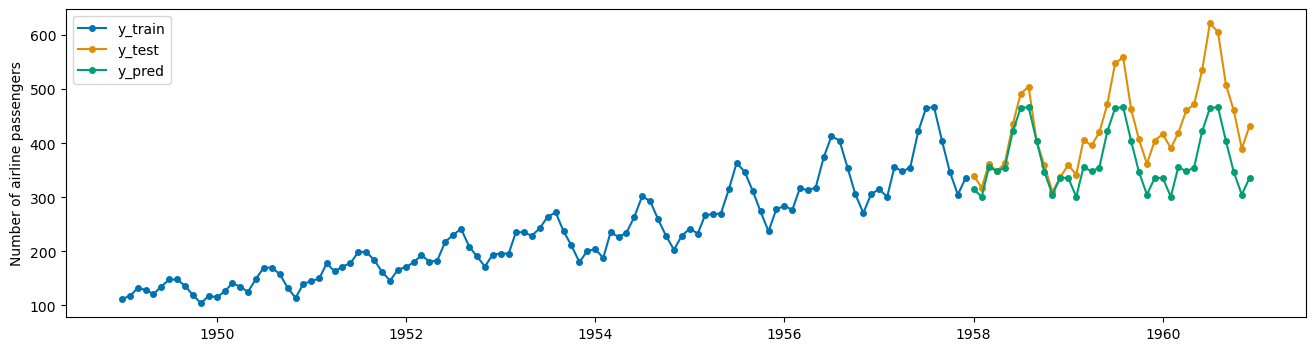

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.13969973841314537

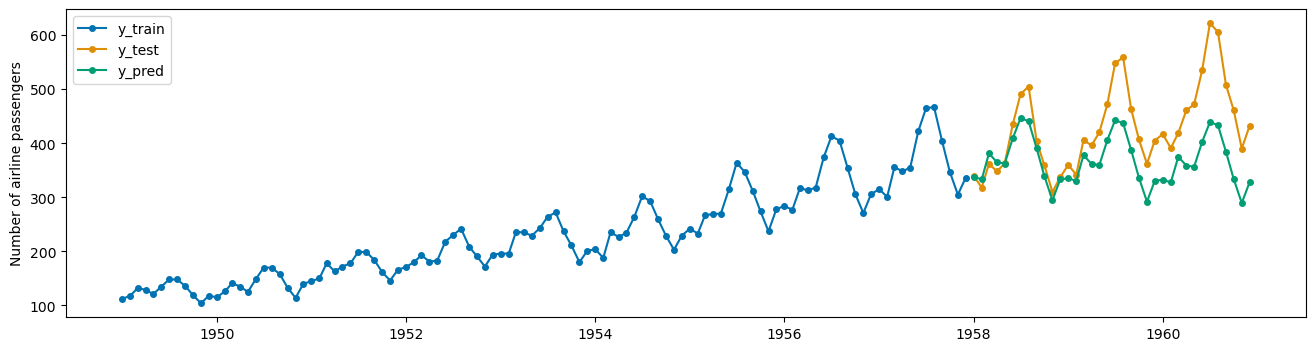

In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("forecast", ARIMA()),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.05610168219537849

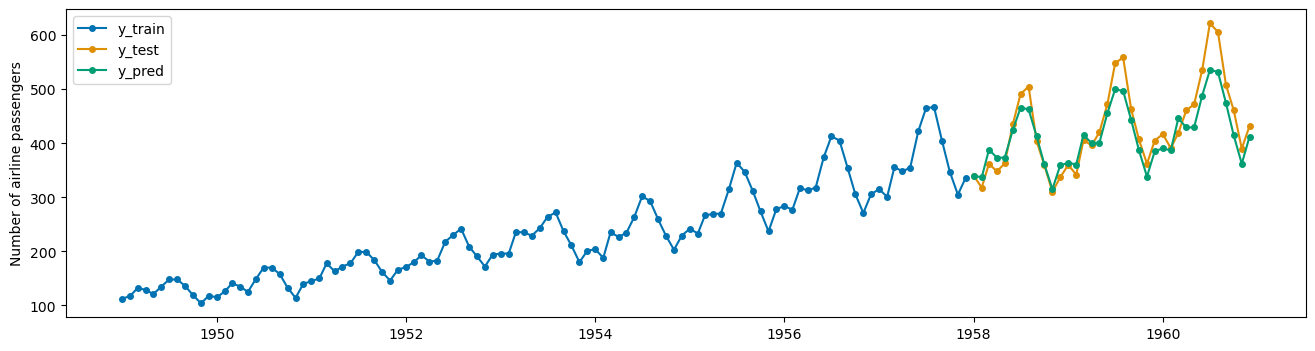

In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA()),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)